In [ ]:
import time

import torch
import torchvision.transforms.v2
from pytorchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
import numpy as np
from tqdm import tqdm
import cv2
import utils
import os
import warnings

from torch import nn, Tensor
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

In [ ]:
class PianoModelBlock(nn.Module):
    def __init__(self, in_dim, out_dim, pad=True, ksize=(3, 3), stride=(1, 1), drop=0.0):
        super().__init__()
        padding = (ksize[0] // 2, ksize[1] // 2) if pad else (0, 0)

        self.main = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(out_dim, out_dim, kernel_size=ksize, stride=stride, bias=False, padding=padding),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=drop),

            nn.Conv2d(out_dim, out_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_dim),
        )

        self.relu = nn.LeakyReLU(inplace=True)

        self.downsample = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=ksize, stride=stride, bias=False, padding=padding),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x: Tensor):
        x = self.relu(self.main(x) + self.downsample(x))
        return x


class PianoModelSmallSelf(nn.Module):
    def __init__(self, input_size=(480, 640), k=5) -> None:
        super().__init__()
        self.k = k
        self.dim_after_preprocessing = 16
        downscale_dim_sizes = [32, 32, 64, 128, 128, 256]

        self.agg_input_frames = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(inplace=True),

            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(inplace=True),

            nn.Conv3d(16, downscale_dim_sizes[0], kernel_size=(self.k - 2, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(downscale_dim_sizes[0]),
            nn.LeakyReLU(inplace=True),
        )

        self.pred_frame_conv = PianoModelBlock(in_dim=1, out_dim=downscale_dim_sizes[0], ksize=(3, 3), stride=1)

        self.blocks = nn.ModuleList([
            PianoModelBlock(in_dim=downscale_dim_sizes[0], out_dim=downscale_dim_sizes[1], ksize=(3, 3), stride=2, drop=0.2),
            PianoModelBlock(in_dim=downscale_dim_sizes[1], out_dim=downscale_dim_sizes[2], ksize=(3, 3), stride=2, drop=0.2),
            PianoModelBlock(in_dim=downscale_dim_sizes[2], out_dim=downscale_dim_sizes[3], ksize=(3, 3), stride=(2, 1), drop=0.2),
            PianoModelBlock(in_dim=downscale_dim_sizes[3], out_dim=downscale_dim_sizes[4], ksize=(3, 3), stride=(2, 1), drop=0.2),
            PianoModelBlock(in_dim=downscale_dim_sizes[4], out_dim=downscale_dim_sizes[5], ksize=(3, 3), stride=(2, 1), drop=0.0),
        ])
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 88))
        self.fc1 = nn.Linear(input_size[0] // 32, 1)
        final_conv_dim = 256
        self.final_conv = nn.Conv1d(downscale_dim_sizes[-1], final_conv_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(input_size[1] // 4 * final_conv_dim, 88)

    def forward(self, x: Tensor):
        pred_frame = self.pred_frame_conv(x[:, :, -1])
        x = self.agg_input_frames(x)

        x = x[:, :, 0] + pred_frame

        for block in self.blocks:
            x = block(x)

        x = torch.moveaxis(x, 2, 3)
        x = self.fc1(x)
        x = x[:, :, :, 0]
        # x = self.avgpool(x)
        x = self.final_conv(x)
        x = self.fc(x.flatten(1))

        return x


# k = 7
# inpt = torch.rand(size=[1, 1, k, 480, 640])
# model = PianoModelSmallSelf(k=k)
# #model = PianoModel()
# print(summary(input_size=inpt.squeeze(0).shape, model=model))
# print("in shape:", inpt.shape)
# print("out shape:", model(inpt).shape)


In [ ]:
fnames = [os.path.join("data", a) for a in os.listdir("data") if ".png" in a]
fnames += [os.path.join("data2", a) for a in os.listdir("data2") if ".png" in a]
fnames += [os.path.join("data3", a) for a in os.listdir("data3") if ".png" in a]
fnames += [os.path.join("data4", a) for a in os.listdir("data4") if ".png" in a]
fnames += [os.path.join("data5", a) for a in os.listdir("data5") if ".png" in a]
fnames = sorted(fnames)
img_fnames = [fname for fname in fnames]
annot_fnames = [fname.replace(".png", ".npy") for fname in fnames]

for a in annot_fnames:
  assert os.path.exists(a), f"{a}"

pbar = tqdm(total=len(fnames))
def f1(img_fname):
  pbar.update(1)
  return cv2.imread(img_fname, cv2.IMREAD_GRAYSCALE)
with ThreadPool(64) as p:
  imgs = p.map(f1, img_fnames)
pbar.close()

pbar = tqdm(total=len(fnames))
def f2(label_fname):
  pbar.update(1)
  return np.load(label_fname)
with ThreadPool(64) as p:
  labels = p.map(f2, annot_fnames)
pbar.close()

100%|████████████████████████████████| 55557/55557 [00:40<00:00, 1385.08it/s]


In [ ]:
class PianoDataset(Dataset):
    def __init__(self, idxs=None, transform=None, k=5):
        self.transform = transform
        self.idxs = idxs if idxs is not None else np.arange(len(img_fnames))
        self.k = k

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        idx = self.idxs[idx]
        image = torch.cat([torch.tensor(imgs[idx + (i - self.k)] / 255, dtype=torch.float32, device="cpu").unsqueeze(0).unsqueeze(0) for i in range(1, self.k + 1)], dim=1)
        label = torch.tensor(labels[idx], dtype=torch.float32, device="cpu")

        if self.transform is not None:
            image = self.transform(image.permute(1, 0, 2, 3)).permute(1, 0, 2, 3)

        return image, label


In [ ]:
def val(model, val_loader, device, threshhold=0.5):
    model.eval()
    accs = []
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            outputs = F.sigmoid(model(batch[0].to(device))) > threshhold
            accs.append((outputs == batch[1].to(device)).to(torch.float32).mean().item())
    del batch
    utils.empty_cache()
    return np.array(accs).mean()

def loss_fn(pred, truth):
    weights = torch.full_like(pred, fill_value=1/10, device=device)
    weights[truth > 0] = 9/10
    return F.binary_cross_entropy_with_logits(pred, truth, weight=weights)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = torchvision.transforms.Compose([
    torchvision.transforms.v2.ColorJitter(brightness=.4, saturation=.4, hue=.5, contrast=.3),
    torchvision.transforms.v2.Lambda(lambda image: F.dropout(image, p=0.05, inplace=True)),
    torchvision.transforms.v2.RandomAffine(degrees=5, translate=(0.05, 0.4)),  # 5, (0, 0.4)
    torchvision.transforms.v2.RandomPerspective(distortion_scale=0.3, p=0.9),  # p=1
])

idxs = np.arange(len(PianoDataset()))
np.random.shuffle(idxs)
num_last_images = 5
train_split = 0.9
train_set = PianoDataset(transform=transform, idxs=idxs[:int(len(idxs) * train_split)], k=num_last_images)
val_set = PianoDataset(idxs=idxs[int(len(idxs) * train_split):], k=num_last_images)

os.makedirs("models", exist_ok=True)

train_dl = DataLoader(train_set,
                      batch_size=40,#utils.find_batch_size(model, dataset=train_set, max_val=16, is_train=True, shuffle=True, device=device),
                      shuffle=True,
                      num_workers=12,
                      )
val_dl = DataLoader(val_set,
                    batch_size=128,#utils.find_batch_size(model, dataset=val_set, max_val=128, is_train=False, shuffle=False, device=device),
                    num_workers=8,
                    )

print(f"batch sizes: ({train_dl.batch_size}, {val_dl.batch_size}), train len: {len(train_dl)}, val len: {len(val_dl)}")

batch sizes: (40, 128), train len: 1251, val len: 44


/gpfs/space/home/karlraud/.conda/envs/llava/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = PianoModelSmallSelf(k=num_last_images)
model.load_state_dict(torch.load("models/model_e14_0.9933"), strict=True)
model = model.to(device).train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_dl))
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer)

In [ ]:
last_val_acc = 0
for epoch in range(epochs):
    print(f"\nepoch {epoch+1}/{epochs}")
    total_loss = 0
    total_acc = 0
    model.train()
    iterator = tqdm(enumerate(train_dl), total=len(train_dl))
    for i, batch in iterator:
        if i == len(train_dl) - 1:  # skip last batch
          continue
        optimizer.zero_grad()

        X, y = batch[0].to(device), batch[1].to(device)
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_acc += ((F.sigmoid(outputs) > 0.5) == y).to(torch.float32).mean().item()
        total_loss += loss.item()
        used, total = utils.get_vram_usage()
        iterator.set_description(
            f"vram: {used:.2f}G/{total:.2f}G "
            f"ram: {utils.get_ram_usage():.2f} "
            f"lr: {optimizer.param_groups[0]['lr']:.8f} "
            f"loss: {total_loss / (i+1):.5f} "
            f"acc: {total_acc / (i+1):.5f} "
            f"val acc: {last_val_acc:.4f} "
        )

    del batch
    del outputs
    utils.empty_cache()

    last_val_acc = val(model, val_dl, device, threshhold=0.5)
    torch.save(model.state_dict(), f"models/model_e{epoch+1}_{last_val_acc:.4f}")


epoch 1/200


vram: 53.02G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00569 acc: 0.98968 val acc: 0.0000 : 100%|█████████████████████████| 1251/1251 [21:23<00:00,  1.03s/it]



epoch 2/200


vram: 54.70G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00540 acc: 0.99016 val acc: 0.9918 : 100%|█████████████████████████| 1251/1251 [21:40<00:00,  1.04s/it]



epoch 3/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00524 acc: 0.99040 val acc: 0.9930 : 100%|█████████████████████████| 1251/1251 [21:53<00:00,  1.05s/it]



epoch 4/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00516 acc: 0.99052 val acc: 0.9930 : 100%|█████████████████████████| 1251/1251 [21:35<00:00,  1.04s/it]



epoch 5/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00502 acc: 0.99071 val acc: 0.9933 : 100%|█████████████████████████| 1251/1251 [21:39<00:00,  1.04s/it]



epoch 6/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00503 acc: 0.99080 val acc: 0.9936 : 100%|█████████████████████████| 1251/1251 [21:33<00:00,  1.03s/it]



epoch 7/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00494 acc: 0.99089 val acc: 0.9924 : 100%|█████████████████████████| 1251/1251 [21:38<00:00,  1.04s/it]



epoch 8/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00489 acc: 0.99097 val acc: 0.9924 : 100%|█████████████████████████| 1251/1251 [21:37<00:00,  1.04s/it]



epoch 9/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00480 acc: 0.99114 val acc: 0.9930 : 100%|█████████████████████████| 1251/1251 [21:33<00:00,  1.03s/it]



epoch 10/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00478 acc: 0.99111 val acc: 0.9929 : 100%|█████████████████████████| 1251/1251 [21:45<00:00,  1.04s/it]



epoch 11/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00474 acc: 0.99120 val acc: 0.9917 : 100%|█████████████████████████| 1251/1251 [21:36<00:00,  1.04s/it]



epoch 12/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00471 acc: 0.99129 val acc: 0.9910 : 100%|█████████████████████████| 1251/1251 [21:41<00:00,  1.04s/it]



epoch 13/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00464 acc: 0.99136 val acc: 0.9929 : 100%|█████████████████████████| 1251/1251 [21:39<00:00,  1.04s/it]



epoch 14/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00463 acc: 0.99141 val acc: 0.9915 : 100%|█████████████████████████| 1251/1251 [21:34<00:00,  1.03s/it]



epoch 15/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00460 acc: 0.99144 val acc: 0.9928 : 100%|█████████████████████████| 1251/1251 [21:40<00:00,  1.04s/it]



epoch 16/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00457 acc: 0.99147 val acc: 0.9924 : 100%|█████████████████████████| 1251/1251 [21:30<00:00,  1.03s/it]



epoch 17/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00451 acc: 0.99157 val acc: 0.9925 : 100%|█████████████████████████| 1251/1251 [21:28<00:00,  1.03s/it]



epoch 18/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00448 acc: 0.99160 val acc: 0.9929 : 100%|█████████████████████████| 1251/1251 [21:42<00:00,  1.04s/it]



epoch 19/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00451 acc: 0.99163 val acc: 0.9935 : 100%|█████████████████████████| 1251/1251 [21:35<00:00,  1.04s/it]



epoch 20/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00445 acc: 0.99163 val acc: 0.9937 : 100%|█████████████████████████| 1251/1251 [21:39<00:00,  1.04s/it]



epoch 21/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00438 acc: 0.99179 val acc: 0.9934 : 100%|█████████████████████████| 1251/1251 [21:45<00:00,  1.04s/it]



epoch 22/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00436 acc: 0.99181 val acc: 0.9940 : 100%|█████████████████████████| 1251/1251 [21:33<00:00,  1.03s/it]



epoch 23/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00435 acc: 0.99187 val acc: 0.9933 : 100%|█████████████████████████| 1251/1251 [21:37<00:00,  1.04s/it]



epoch 24/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00435 acc: 0.99187 val acc: 0.9930 : 100%|█████████████████████████| 1251/1251 [21:32<00:00,  1.03s/it]



epoch 25/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00429 acc: 0.99196 val acc: 0.9934 : 100%|█████████████████████████| 1251/1251 [21:32<00:00,  1.03s/it]



epoch 26/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00428 acc: 0.99198 val acc: 0.9935 : 100%|█████████████████████████| 1251/1251 [21:50<00:00,  1.05s/it]



epoch 27/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00429 acc: 0.99196 val acc: 0.9927 : 100%|█████████████████████████| 1251/1251 [21:34<00:00,  1.03s/it]



epoch 28/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00421 acc: 0.99207 val acc: 0.9934 : 100%|█████████████████████████| 1251/1251 [21:31<00:00,  1.03s/it]



epoch 29/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00422 acc: 0.99209 val acc: 0.9932 : 100%|█████████████████████████| 1251/1251 [21:34<00:00,  1.03s/it]



epoch 30/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00416 acc: 0.99213 val acc: 0.9938 : 100%|█████████████████████████| 1251/1251 [21:37<00:00,  1.04s/it]



epoch 31/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00411 acc: 0.99227 val acc: 0.9941 : 100%|█████████████████████████| 1251/1251 [21:55<00:00,  1.05s/it]



epoch 32/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00415 acc: 0.99214 val acc: 0.9942 : 100%|█████████████████████████| 1251/1251 [21:33<00:00,  1.03s/it]



epoch 33/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00409 acc: 0.99224 val acc: 0.9934 : 100%|█████████████████████████| 1251/1251 [21:35<00:00,  1.04s/it]



epoch 34/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00409 acc: 0.99230 val acc: 0.9942 : 100%|█████████████████████████| 1251/1251 [21:35<00:00,  1.04s/it]



epoch 35/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00404 acc: 0.99235 val acc: 0.9932 : 100%|█████████████████████████| 1251/1251 [21:40<00:00,  1.04s/it]



epoch 36/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00404 acc: 0.99236 val acc: 0.9922 : 100%|█████████████████████████| 1251/1251 [21:45<00:00,  1.04s/it]



epoch 37/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00407 acc: 0.99233 val acc: 0.9927 : 100%|█████████████████████████| 1251/1251 [21:40<00:00,  1.04s/it]



epoch 38/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00399 acc: 0.99244 val acc: 0.9939 : 100%|█████████████████████████| 1251/1251 [21:42<00:00,  1.04s/it]



epoch 39/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00398 acc: 0.99246 val acc: 0.9930 : 100%|█████████████████████████| 1251/1251 [21:39<00:00,  1.04s/it]



epoch 40/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00393 acc: 0.99255 val acc: 0.9934 : 100%|█████████████████████████| 1251/1251 [21:31<00:00,  1.03s/it]



epoch 41/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00396 acc: 0.99246 val acc: 0.9929 : 100%|█████████████████████████| 1251/1251 [21:33<00:00,  1.03s/it]



epoch 42/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00396 acc: 0.99258 val acc: 0.9943 : 100%|█████████████████████████| 1251/1251 [21:45<00:00,  1.04s/it]



epoch 43/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00390 acc: 0.99260 val acc: 0.9920 : 100%|█████████████████████████| 1251/1251 [21:34<00:00,  1.03s/it]



epoch 44/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00389 acc: 0.99263 val acc: 0.9934 : 100%|█████████████████████████| 1251/1251 [21:39<00:00,  1.04s/it]



epoch 45/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00388 acc: 0.99263 val acc: 0.9945 : 100%|█████████████████████████| 1251/1251 [21:50<00:00,  1.05s/it]



epoch 46/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00385 acc: 0.99266 val acc: 0.9948 : 100%|█████████████████████████| 1251/1251 [21:39<00:00,  1.04s/it]



epoch 47/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00381 acc: 0.99276 val acc: 0.9936 : 100%|█████████████████████████| 1251/1251 [21:35<00:00,  1.04s/it]



epoch 48/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00380 acc: 0.99274 val acc: 0.9935 : 100%|█████████████████████████| 1251/1251 [21:42<00:00,  1.04s/it]



epoch 49/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00382 acc: 0.99275 val acc: 0.9942 : 100%|█████████████████████████| 1251/1251 [21:52<00:00,  1.05s/it]



epoch 50/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00380 acc: 0.99274 val acc: 0.9948 : 100%|█████████████████████████| 1251/1251 [21:34<00:00,  1.03s/it]



epoch 51/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00379 acc: 0.99282 val acc: 0.9931 : 100%|█████████████████████████| 1251/1251 [21:36<00:00,  1.04s/it]



epoch 52/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00376 acc: 0.99281 val acc: 0.9937 : 100%|█████████████████████████| 1251/1251 [21:38<00:00,  1.04s/it]



epoch 53/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00375 acc: 0.99283 val acc: 0.9932 : 100%|█████████████████████████| 1251/1251 [21:25<00:00,  1.03s/it]



epoch 54/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00371 acc: 0.99289 val acc: 0.9946 : 100%|█████████████████████████| 1251/1251 [21:31<00:00,  1.03s/it]



epoch 55/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00370 acc: 0.99288 val acc: 0.9932 : 100%|█████████████████████████| 1251/1251 [21:41<00:00,  1.04s/it]



epoch 56/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00371 acc: 0.99289 val acc: 0.9934 : 100%|█████████████████████████| 1251/1251 [21:26<00:00,  1.03s/it]



epoch 57/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00366 acc: 0.99300 val acc: 0.9946 : 100%|█████████████████████████| 1251/1251 [21:24<00:00,  1.03s/it]



epoch 58/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00369 acc: 0.99298 val acc: 0.9937 : 100%|█████████████████████████| 1251/1251 [21:19<00:00,  1.02s/it]



epoch 59/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00367 acc: 0.99300 val acc: 0.9940 : 100%|█████████████████████████| 1251/1251 [21:24<00:00,  1.03s/it]



epoch 60/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00362 acc: 0.99309 val acc: 0.9943 : 100%|█████████████████████████| 1251/1251 [21:47<00:00,  1.05s/it]



epoch 61/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00364 acc: 0.99301 val acc: 0.9947 : 100%|█████████████████████████| 1251/1251 [21:30<00:00,  1.03s/it]



epoch 62/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00364 acc: 0.99302 val acc: 0.9941 : 100%|█████████████████████████| 1251/1251 [21:27<00:00,  1.03s/it]



epoch 63/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00359 acc: 0.99313 val acc: 0.9939 : 100%|█████████████████████████| 1251/1251 [21:25<00:00,  1.03s/it]



epoch 64/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00358 acc: 0.99315 val acc: 0.9935 : 100%|█████████████████████████| 1251/1251 [21:19<00:00,  1.02s/it]



epoch 65/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00352 acc: 0.99328 val acc: 0.9939 : 100%|█████████████████████████| 1251/1251 [21:41<00:00,  1.04s/it]



epoch 66/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00355 acc: 0.99320 val acc: 0.9944 : 100%|█████████████████████████| 1251/1251 [21:25<00:00,  1.03s/it]



epoch 67/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00354 acc: 0.99322 val acc: 0.9932 : 100%|█████████████████████████| 1251/1251 [21:31<00:00,  1.03s/it]



epoch 68/200


vram: 54.67G/84.99G ram: 0.06 lr: 0.00100000 loss: 0.00357 acc: 0.99314 val acc: 0.9941 : 100%|█████████████████████████| 1251/1251 [21:33<00:00,  1.03s/it]



epoch 69/200


vram: 54.67G/84.99G ram: 0.09 lr: 0.00100000 loss: 0.00352 acc: 0.99326 val acc: 0.9947 : 100%|█████████████████████████| 1251/1251 [24:39<00:00,  1.18s/it]



epoch 70/200


vram: 54.67G/84.99G ram: 0.07 lr: 0.00100000 loss: 0.00349 acc: 0.99327 val acc: 0.9942 : 100%|█████████████████████████| 1251/1251 [24:58<00:00,  1.20s/it]



epoch 71/200


vram: 54.67G/84.99G ram: 0.10 lr: 0.00100000 loss: 0.00351 acc: 0.99327 val acc: 0.9945 :  67%|█████████████████▎        | 832/1251 [18:28<09:30,  1.36s/it]

In [ ]:
model = PianoModelSmallSelf(k=num_last_images)
model.load_state_dict(torch.load("models/model_e1_0.9953"), strict=False)
model = model.to(device).eval()


threshholds = np.arange(0, 1.01, 0.01)
accs = dict()
with torch.no_grad():
    for i, batch in tqdm(enumerate(val_dl), total=len(val_dl)):
        outputs = F.sigmoid(model(batch[0].to(device)))
        l = batch[1].to(device)
        for thresh in threshholds:
          o = outputs > thresh
          accs[thresh] = accs.get(thresh, []) + [(o == l).to(torch.float32).mean().item()]
del batch
utils.empty_cache()
for x, v in accs.items():
  accs[x] = np.array(v).mean()
for x, v in accs.items():
  print(f"{x:.2f}: {v:.5f}" + (" best" if v == max(accs.values()) else ""))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:37<00:00,  1.18it/s]


0.00: 0.02240
0.01: 0.97655
0.02: 0.98506
0.03: 0.98852
0.04: 0.99029
0.05: 0.99139
0.06: 0.99223
0.07: 0.99284
0.08: 0.99329
0.09: 0.99360
0.10: 0.99386
0.11: 0.99406
0.12: 0.99426
0.13: 0.99444
0.14: 0.99456
0.15: 0.99469
0.16: 0.99479
0.17: 0.99485
0.18: 0.99489
0.19: 0.99496
0.20: 0.99500
0.21: 0.99508
0.22: 0.99512
0.23: 0.99514
0.24: 0.99518
0.25: 0.99523
0.26: 0.99528
0.27: 0.99529
0.28: 0.99531
0.29: 0.99534
0.30: 0.99534
0.31: 0.99538
0.32: 0.99541
0.33: 0.99543
0.34: 0.99544
0.35: 0.99546
0.36: 0.99546
0.37: 0.99546
0.38: 0.99546
0.39: 0.99546
0.40: 0.99545
0.41: 0.99545
0.42: 0.99546 best
0.43: 0.99545
0.44: 0.99543
0.45: 0.99540
0.46: 0.99541
0.47: 0.99540
0.48: 0.99538
0.49: 0.99534
0.50: 0.99532
0.51: 0.99528
0.52: 0.99529
0.53: 0.99526
0.54: 0.99523
0.55: 0.99519
0.56: 0.99515
0.57: 0.99512
0.58: 0.99509
0.59: 0.99506
0.60: 0.99504
0.61: 0.99501
0.62: 0.99496
0.63: 0.99492
0.64: 0.99487
0.65: 0.99483
0.66: 0.99478
0.67: 0.99475
0.68: 0.99468
0.69: 0.99464
0.70: 0.99457
0

In [ ]:
def f_score(model, val_loader, device, threshhold=0.9):
    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_loader), total=len(val_loader)):
            outputs = F.sigmoid(model(batch[0].to(device))) > threshhold
            preds += list(outputs.cpu().numpy())
            gts += list(batch[1].cpu().numpy())
    from sklearn.metrics import f1_score
    del batch
    utils.empty_cache()
    return f1_score(gts, preds, average=None, zero_division=1.0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_set = PianoDataset(k=5)
all_dl = DataLoader(all_set,
                    batch_size=32,
                    num_workers=12,
                    )
model = PianoModelSmallSelf(k=5)
model.load_state_dict(torch.load("best_model"), strict=True)
model = model.to(device).eval()
f_scores_per_class = f_score(model, all_dl, device)

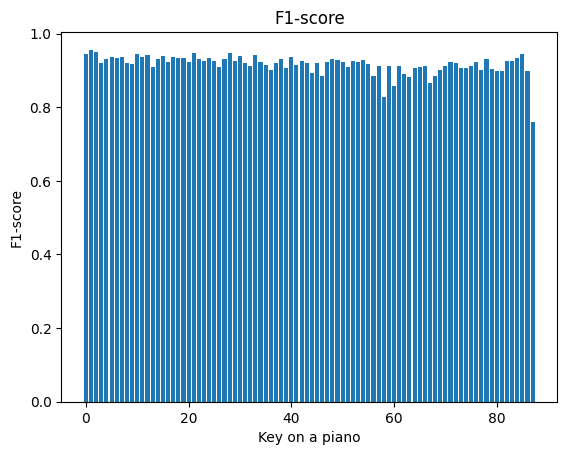

In [ ]:
from matplotlib import pyplot as plt
plt.bar(list(range(88)), f_scores_per_class)
plt.title("F1-score")
plt.xlabel("Key on a piano")
plt.ylabel("F1-score")
plt.show()